##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

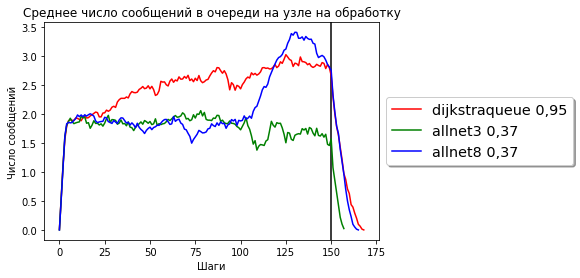

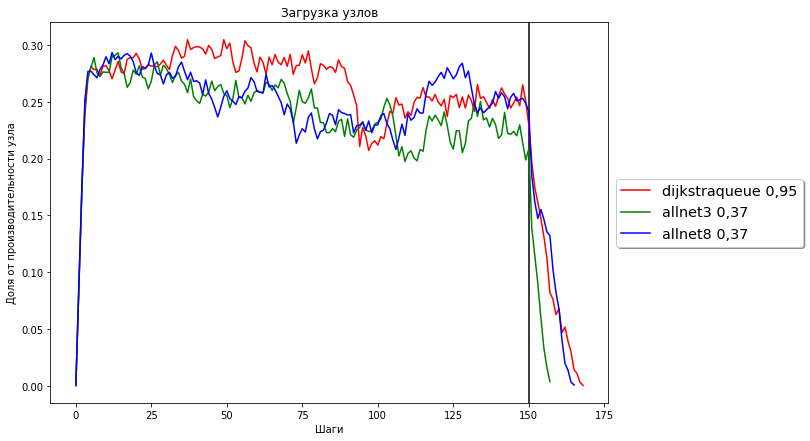

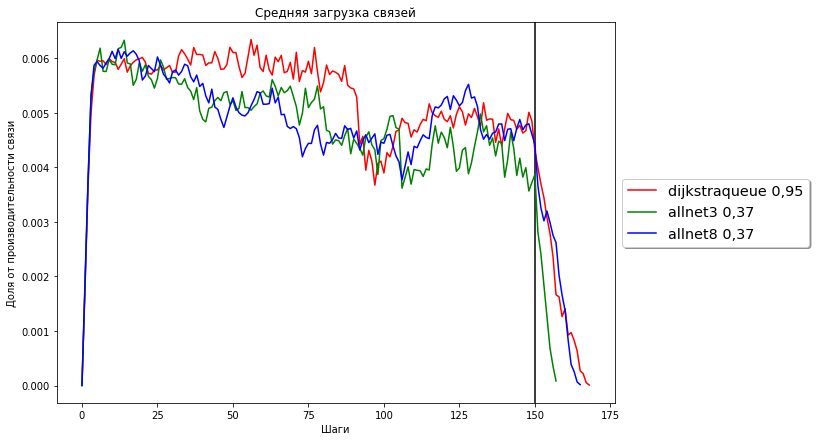

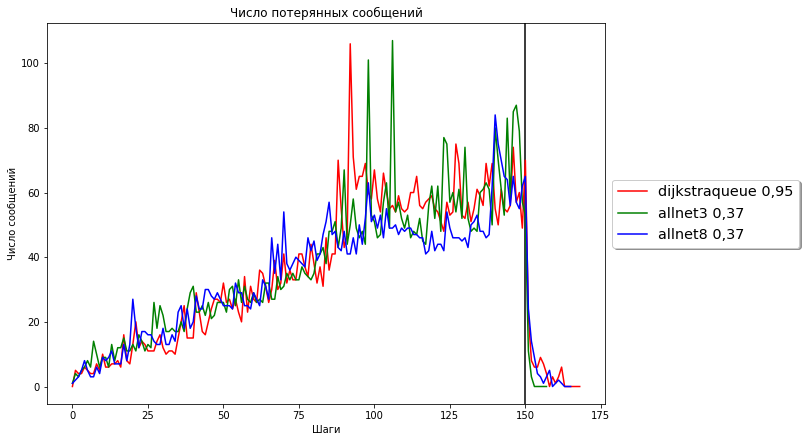

Доставлено 9311 Потеряно 37.9308% -dijkstraqueue 0,95
Доставлено 9297 Потеряно 38.0241% -allnet3 0,37
Доставлено 9619 Потеряно 35.8776% -allnet8 0,37


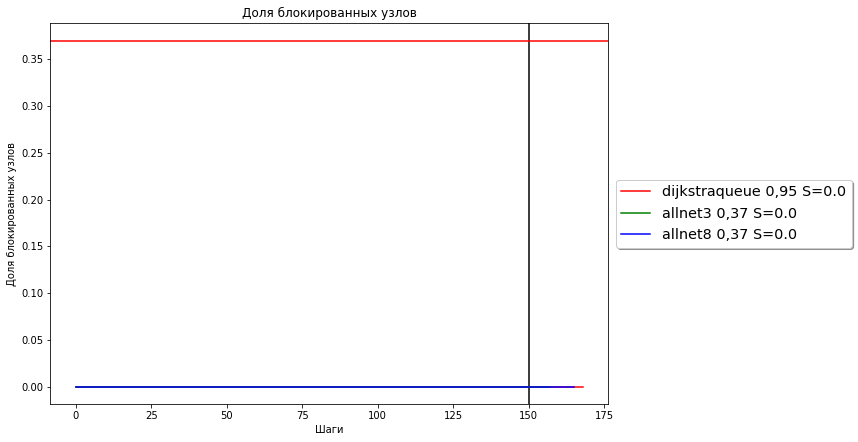

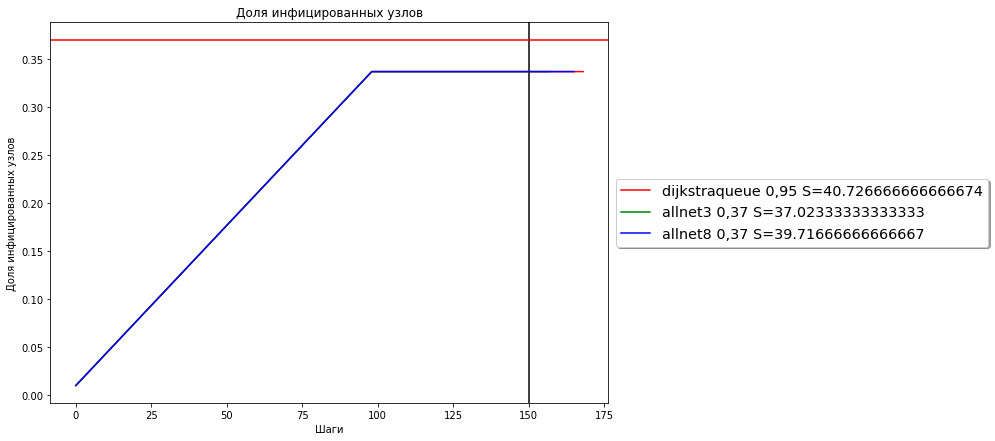

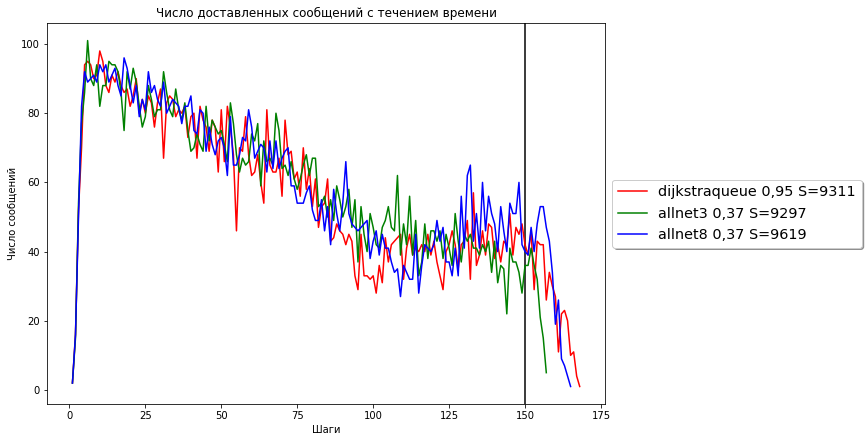

In [2]:
quantity = 100;
log_tags = [
{"tag":  "8af30bfc-0fba-4996-8996-425f286a3bd3", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "46ab34bf-7e24-406f-8517-41618d57dd62", "label": "allnet3 0,37", "color": "green"},
{"tag":  "11e92663-d81a-4f93-97a0-5cdaa0373070", "label": "allnet8 0,37", "color": "blue"},
]                        
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

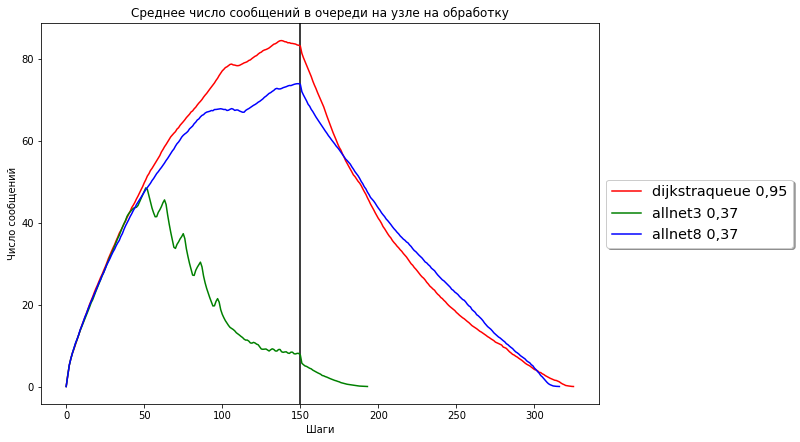

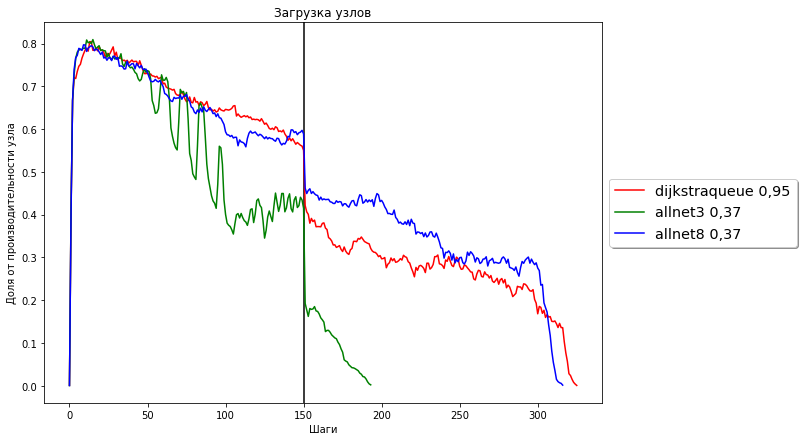

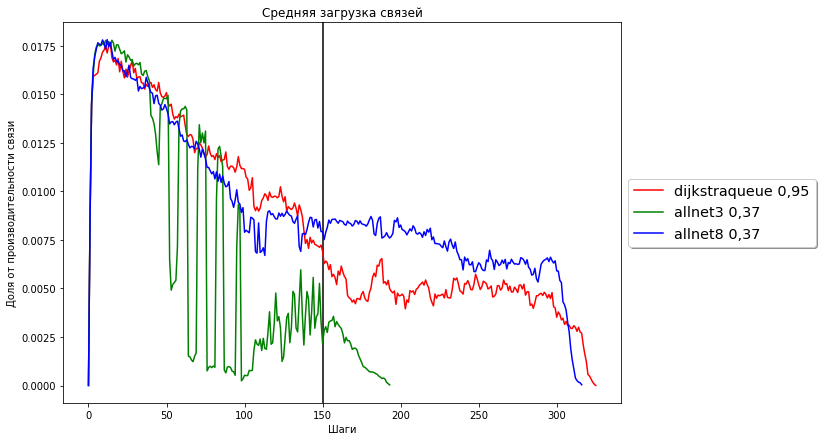

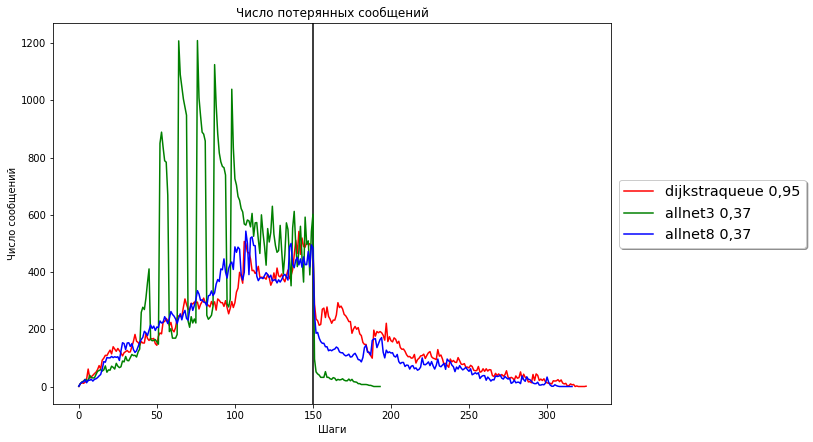

Доставлено 17375 Потеряно 76.8336% -dijkstraqueue 0,95
Доставлено 11318 Потеряно 84.9095% -allnet3 0,37
Доставлено 21450 Потеряно 71.4004% -allnet8 0,37


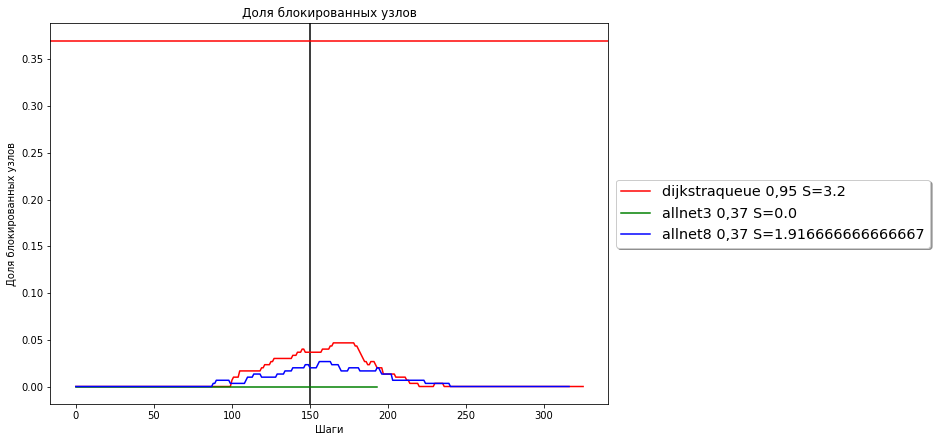

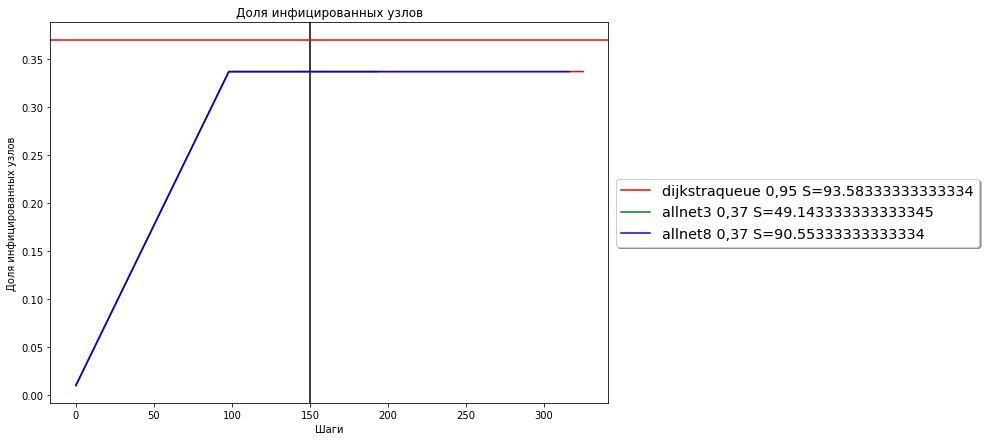

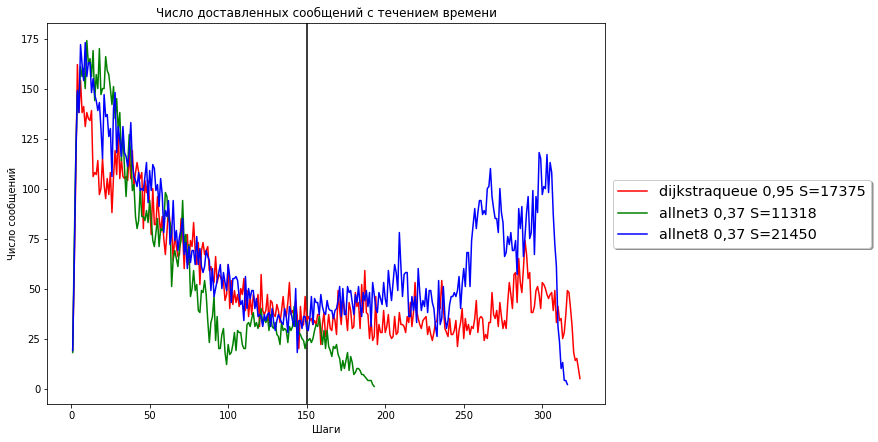

In [3]:
quantity = 500;
log_tags = [
{"tag":  "386544ad-8684-4911-9a49-249090e9339a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "2b277542-9ece-4166-b0d6-93725317c2a7", "label": "allnet3 0,37", "color": "green"},
{"tag":  "e3dc1a4c-3e94-439a-8f0c-d9afe4e4e2ef", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

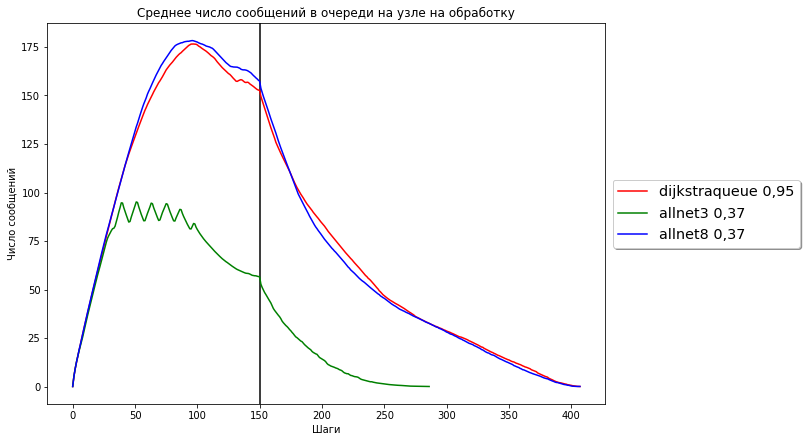

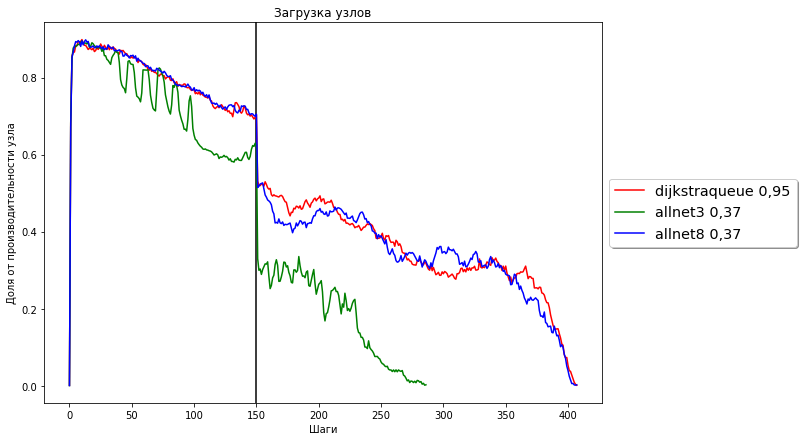

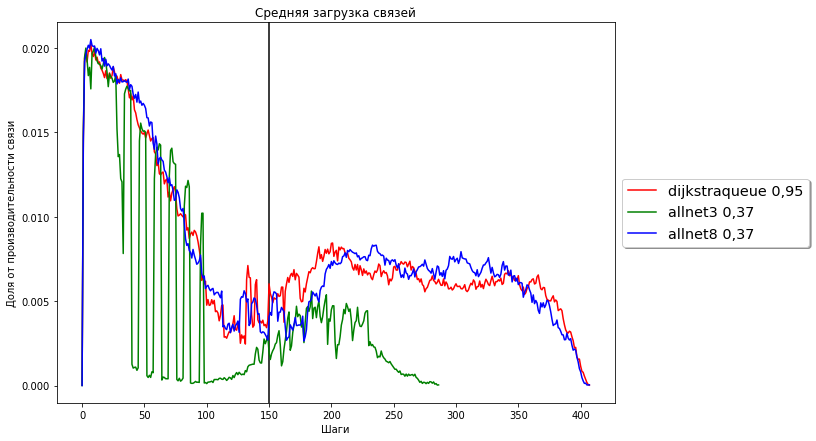

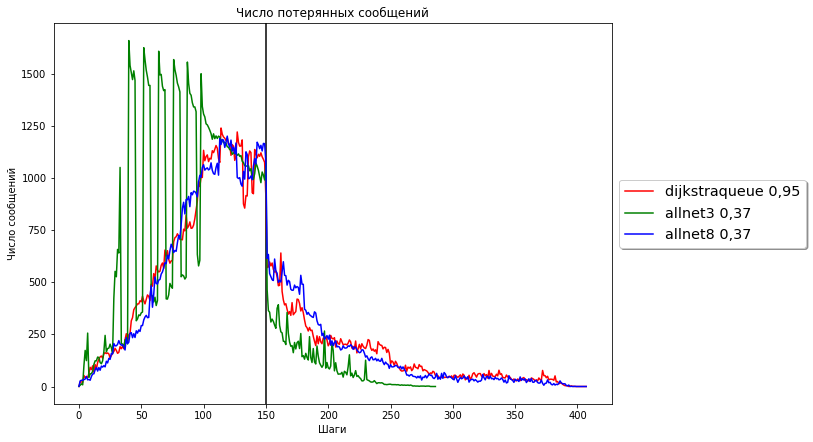

Доставлено 16776 Потеряно 88.8161% -dijkstraqueue 0,95
Доставлено 9248 Потеряно 93.8347% -allnet3 0,37
Доставлено 19164 Потеряно 87.2241% -allnet8 0,37


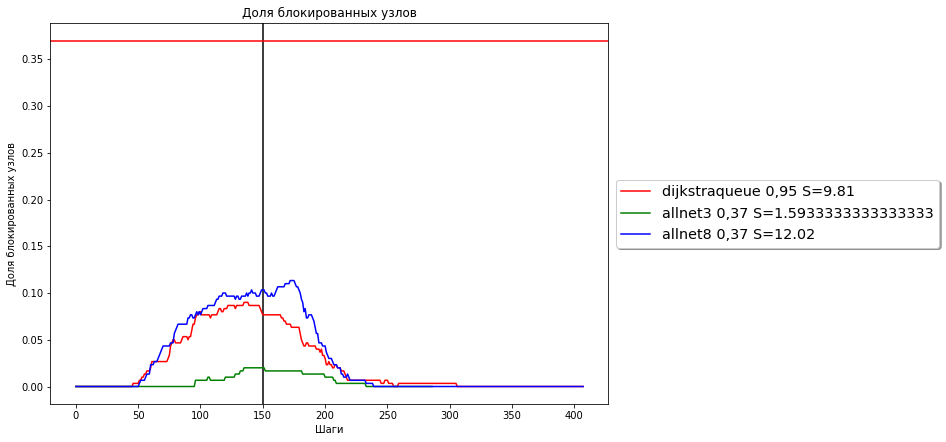

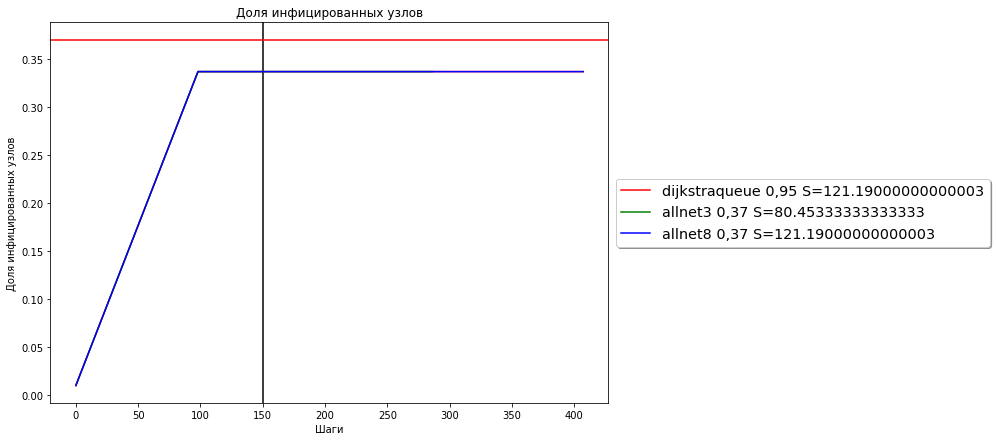

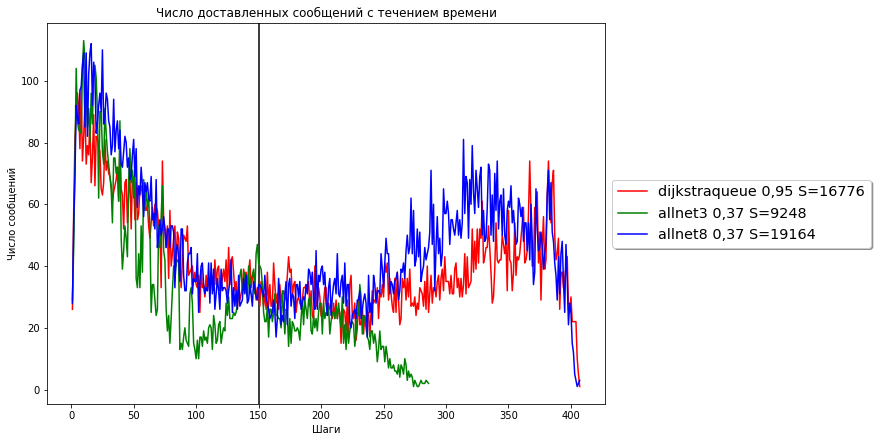

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "f0213292-b04f-4abd-b788-52921df9ef3d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c16e35b0-7b1e-4d3d-a9de-baec33049ab4", "label": "allnet3 0,37", "color": "green"},
{"tag":  "8cd078f4-0e41-4cde-b83d-7059031030d9", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

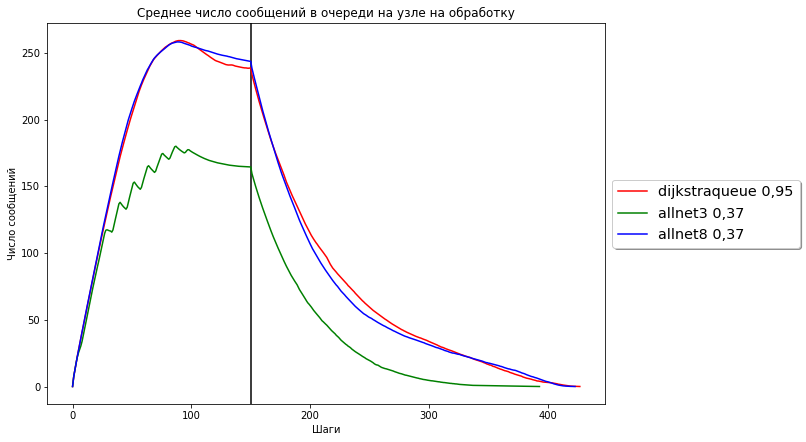

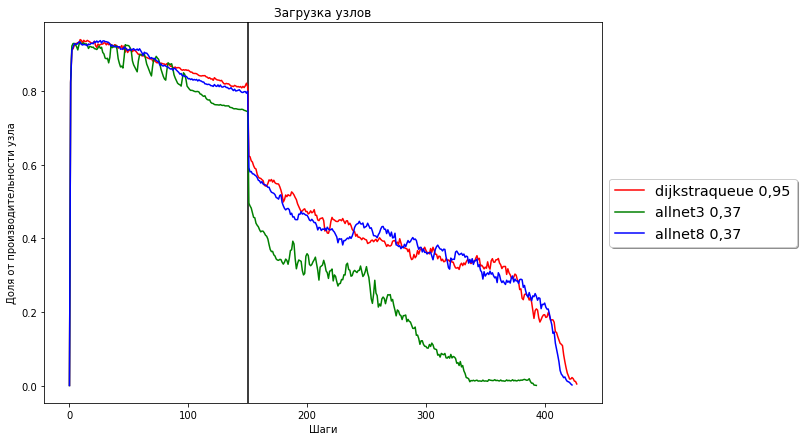

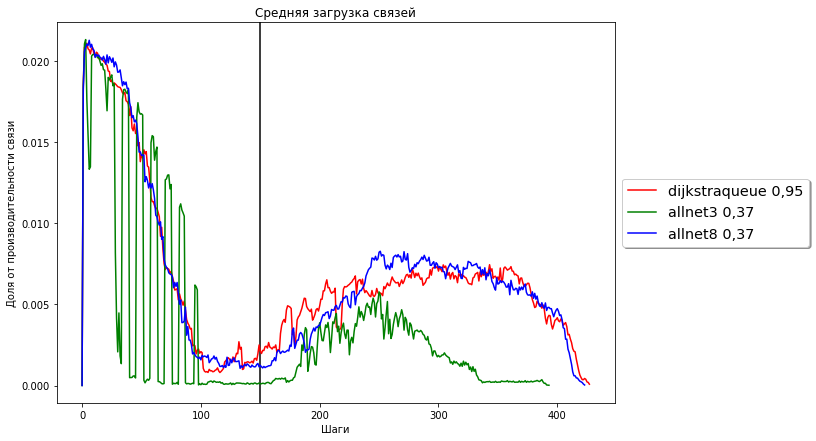

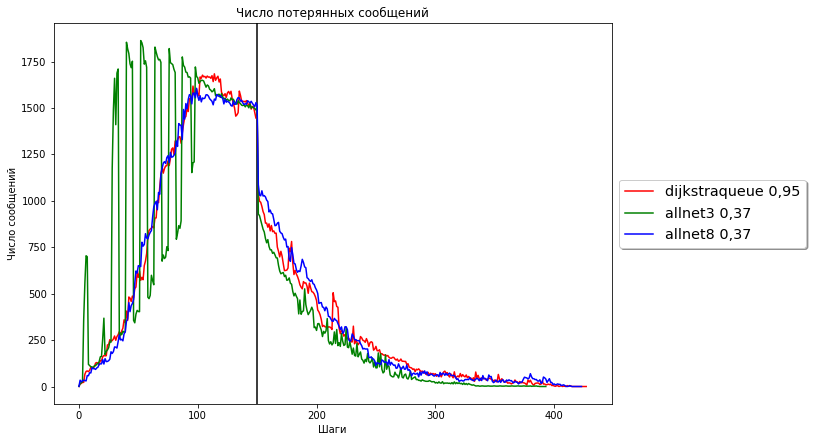

Доставлено 16387 Потеряно 92.7169% -dijkstraqueue 0,95
Доставлено 7852 Потеряно 96.5102% -allnet3 0,37
Доставлено 15601 Потеряно 93.0663% -allnet8 0,37


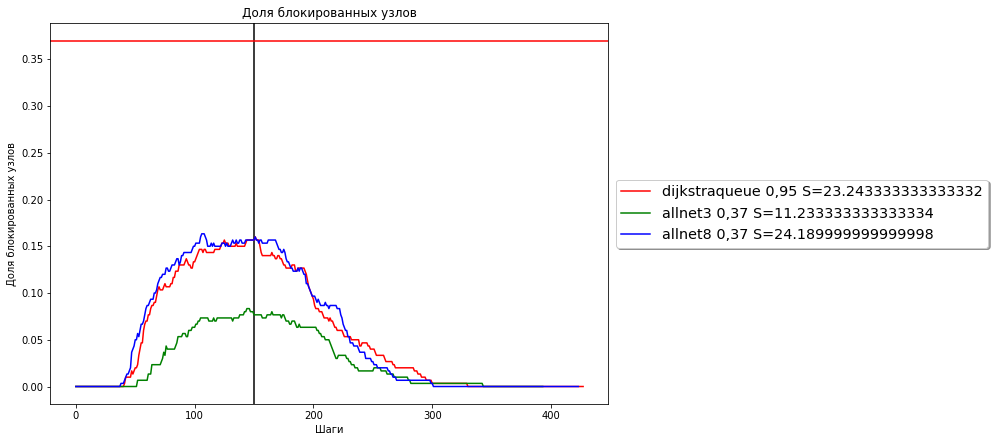

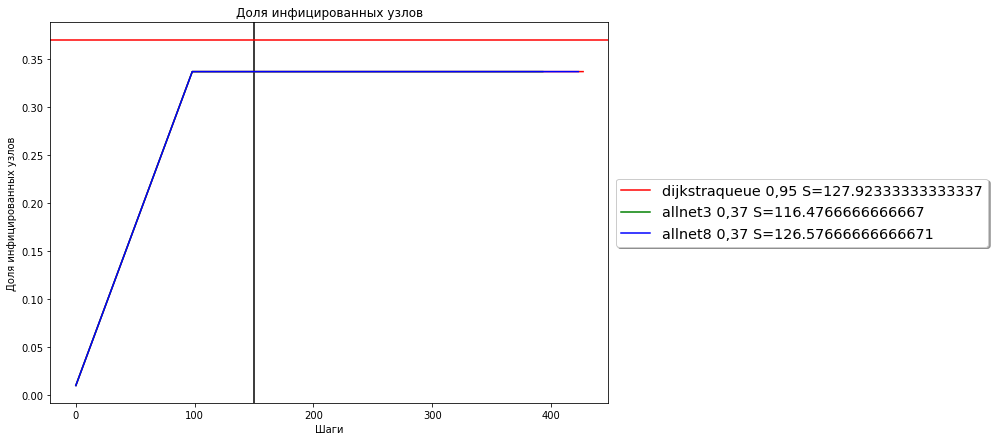

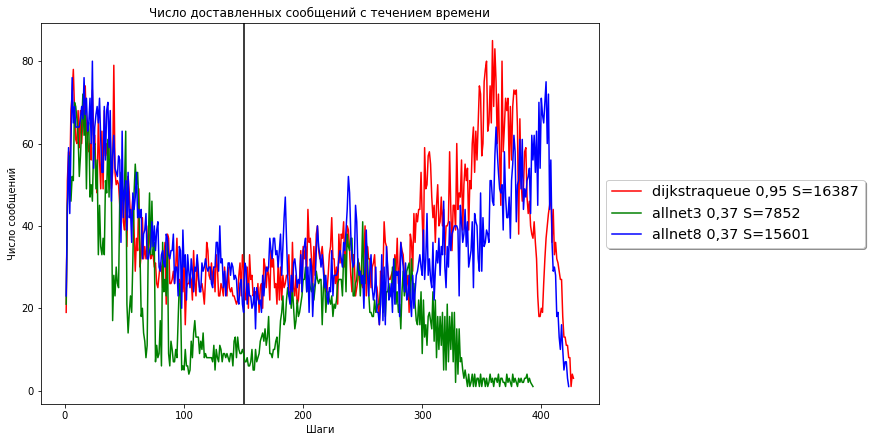

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "b59f3a6b-6ef3-4ad7-9c11-dae59d25444a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "04dcd39e-c225-4cdb-a561-d73ed22ae8ef", "label": "allnet3 0,37", "color": "green"},
{"tag":  "d50d7e87-d4c1-4469-9307-802f3430d78d", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 18798 Потеряно 58.2276% -dijkstraqueue 0,95
Доставлено 12827 Потеряно 71.4962% -allnet3 0,37
Доставлено 21635 Потеряно 51.9233% -allnet8 0,37


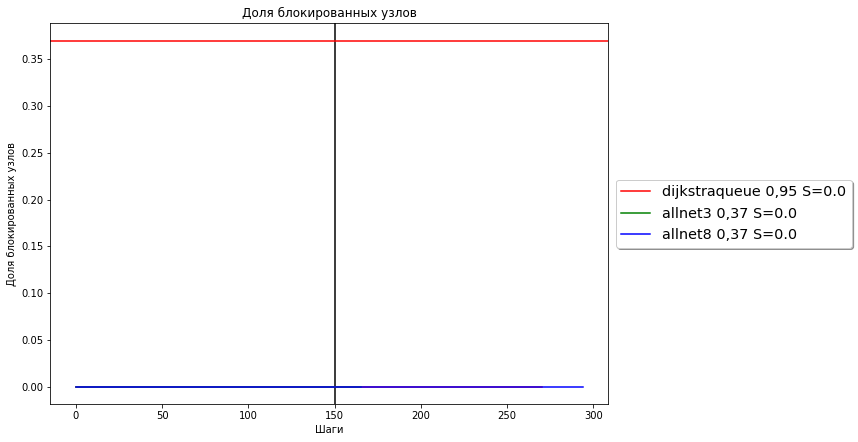

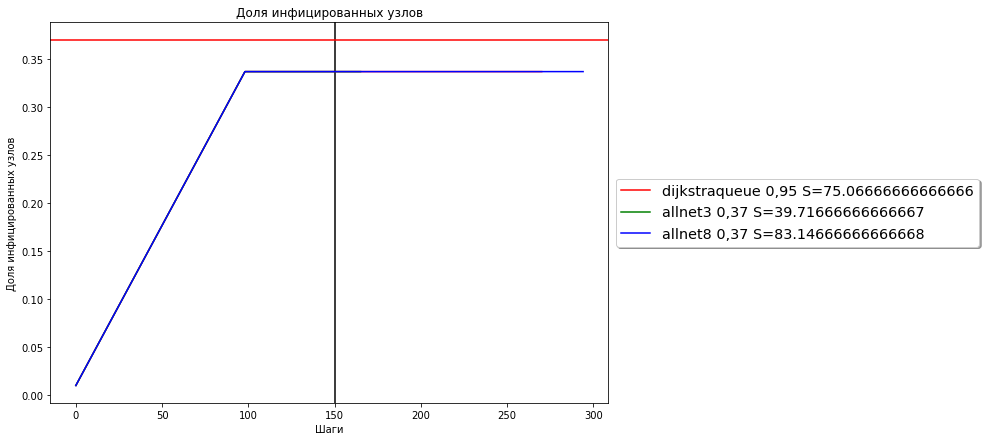

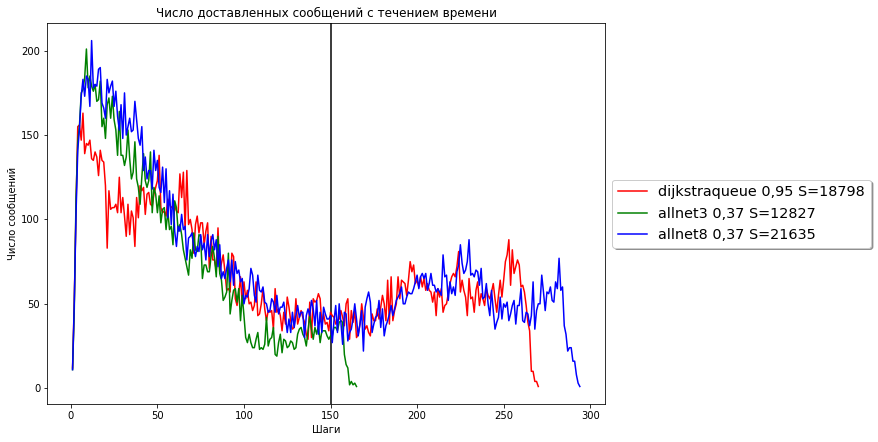

Доставлено 17952 Потеряно 82.9030% -dijkstraqueue 0,95
Доставлено 9939 Потеряно 90.5344% -allnet3 0,37
Доставлено 20319 Потеряно 80.6488% -allnet8 0,37


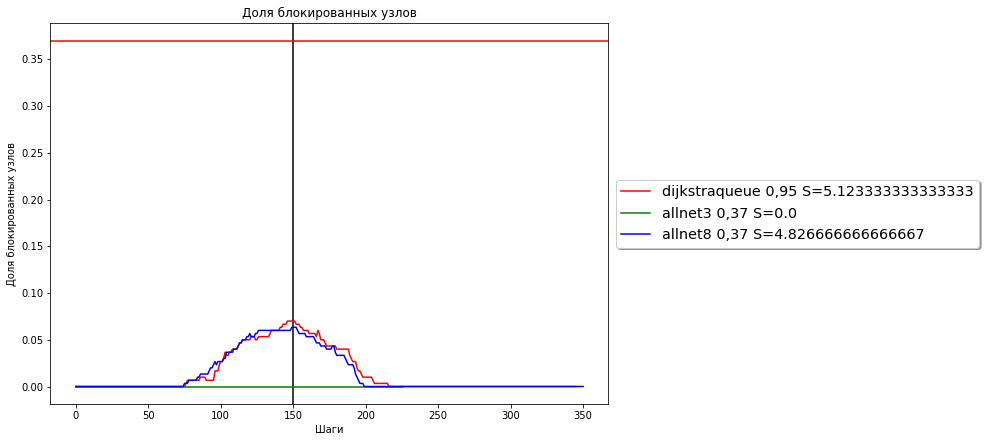

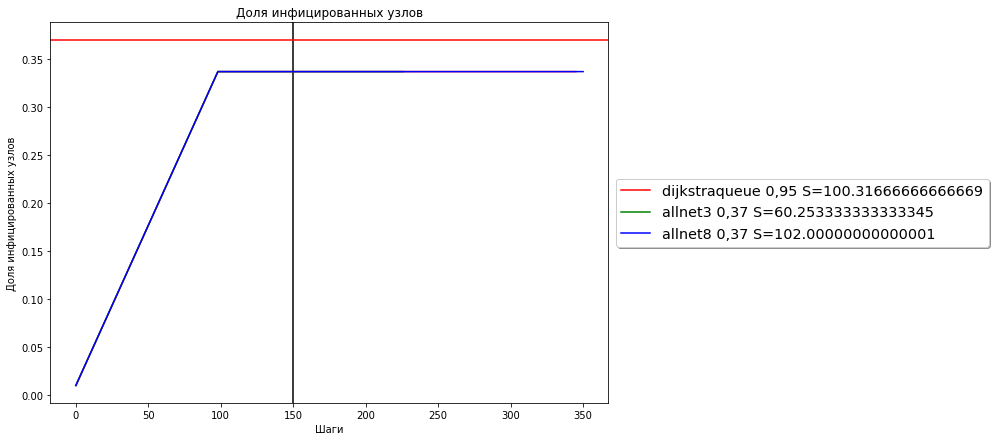

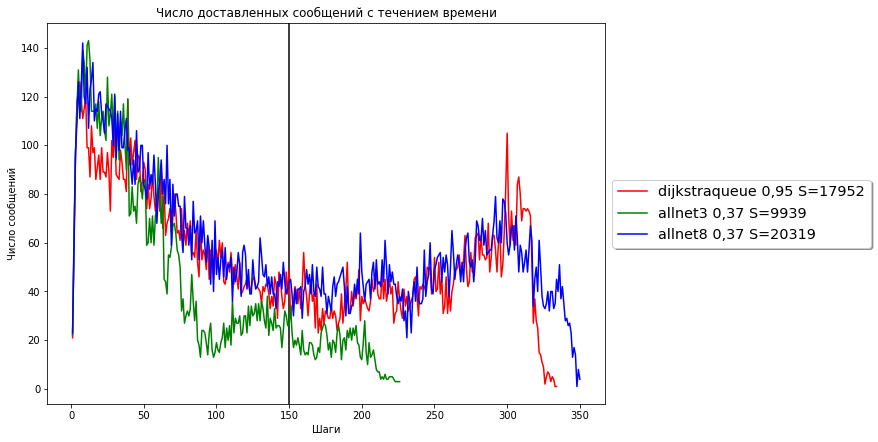

Доставлено 15433 Потеряно 88.5682% -dijkstraqueue 0,95
Доставлено 9202 Потеряно 93.1838% -allnet3 0,37
Доставлено 18024 Потеряно 86.6490% -allnet8 0,37


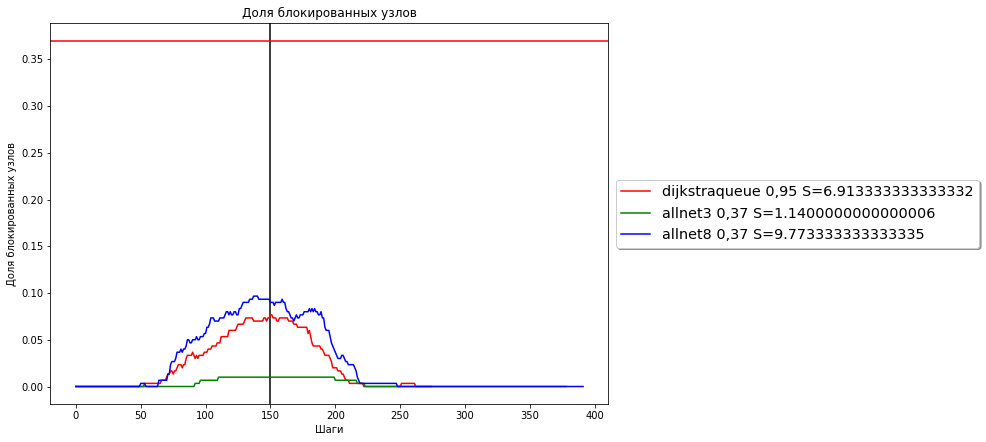

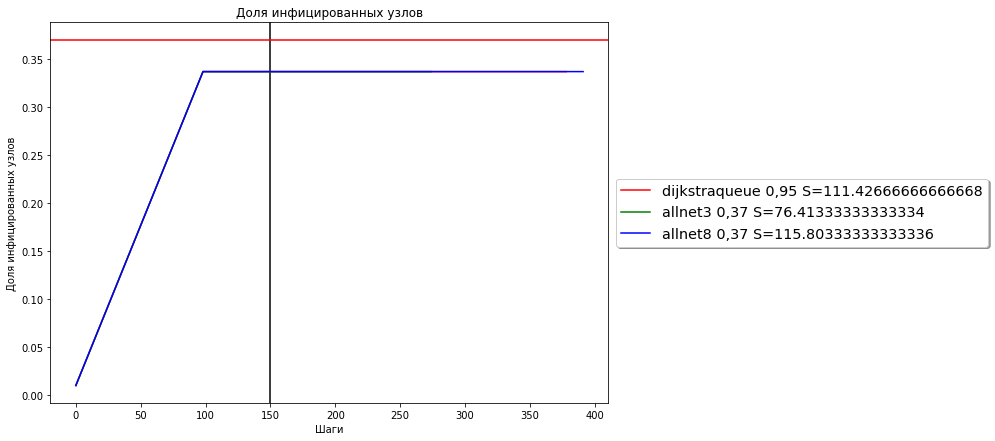

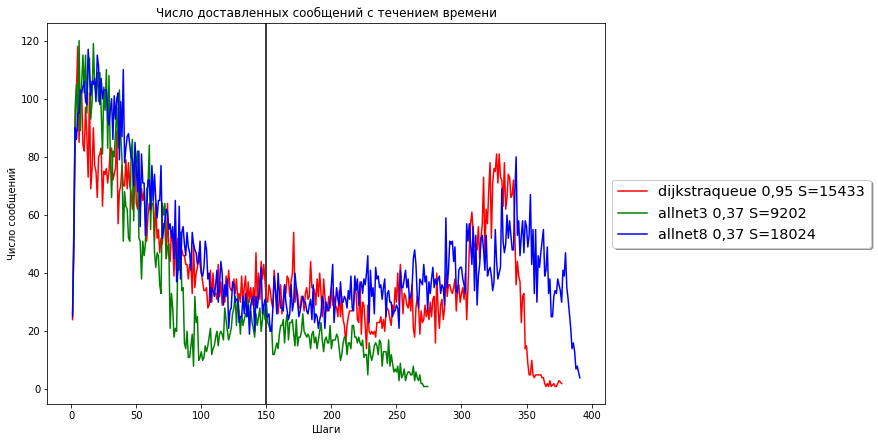

Доставлено 15667 Потеряно 91.9657% -dijkstraqueue 0,95
Доставлено 7460 Потеряно 96.1744% -allnet3 0,37
Доставлено 14719 Потеряно 92.4518% -allnet8 0,37


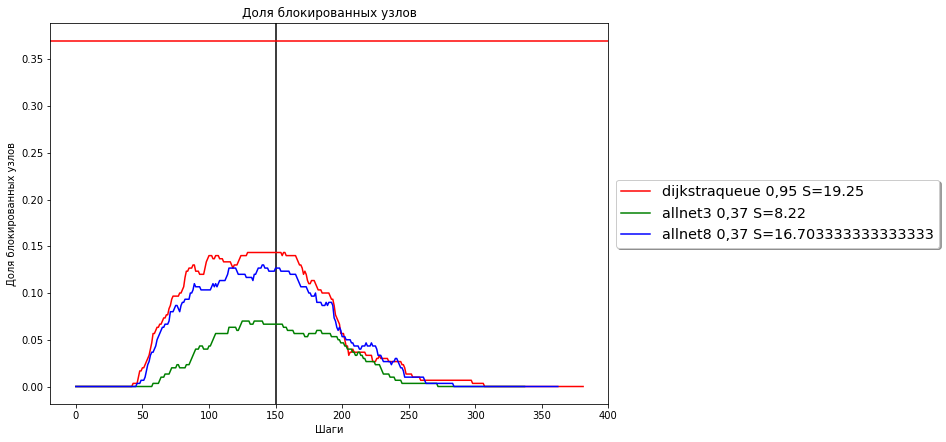

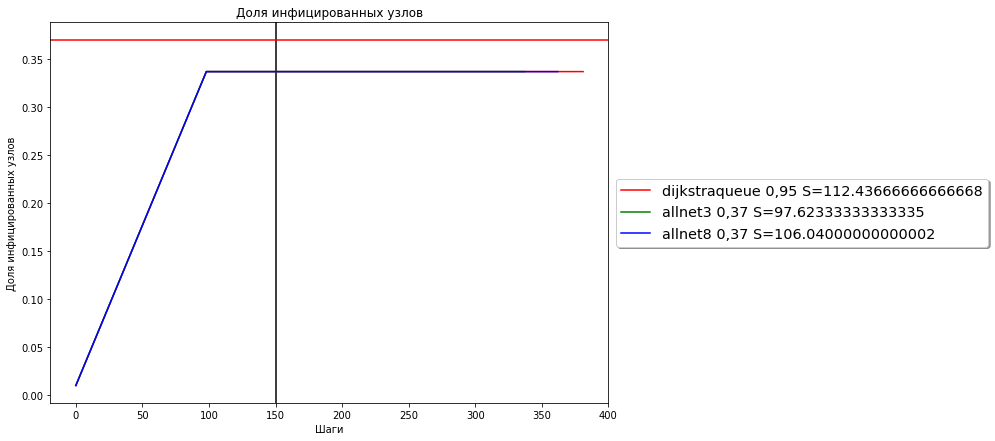

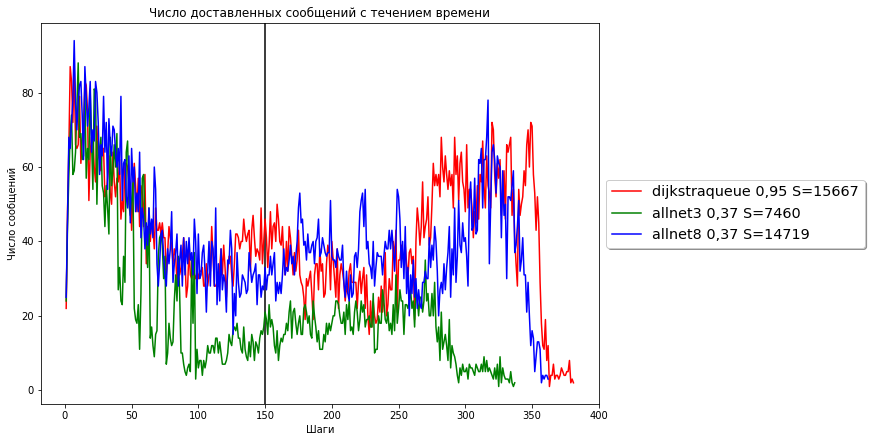

In [6]:
quantity = 300;
log_tags = [
{"tag":  "4a7a89d2-4ad1-42e0-a0bd-8fd50529ccd7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "82699b63-d864-41cb-99bf-3d61ef5cfb89", "label": "allnet3 0,37", "color": "green"},
{"tag":  "e75660eb-7f8a-4bfd-87c6-9df5271358c2", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "9c4ffecc-577d-4688-9438-099ffa26ce8a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7d0ab003-c0b5-4aef-bb77-403b727f9972", "label": "allnet3 0,37", "color": "green"},
{"tag":  "b5f65e4b-dac0-41be-90d8-d84be3c853e9", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "74bb1037-8948-409e-8bcf-dde043099208", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "11ba2a5f-b6b5-4a08-a137-a56948fb1883", "label": "allnet3 0,37", "color": "green"},
{"tag":  "3ea86e5d-b8cb-4c5d-b310-d59a51efcdbd", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "63c0a379-b46f-4893-aeb8-ab5546f1326b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ed7ca9c3-ccd7-43e2-8821-e09ce66cb94b", "label": "allnet3 0,37", "color": "green"},
{"tag":  "f3a931fc-90ff-460a-8c15-4ba2d0b5f1ea", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,37  allnet8 0,37
100             5.570229      3.450970      4.574495
300            36.293260      9.621497     40.309904
500            53.368702     14.028253     50.734804
700            55.020800     17.614013     56.976524
900            56.186302     22.701550     58.417123
1000           62.600716     24.774882     62.781881
1300           55.401203     34.281737     54.622894
1500           61.636828     38.400407     61.126039


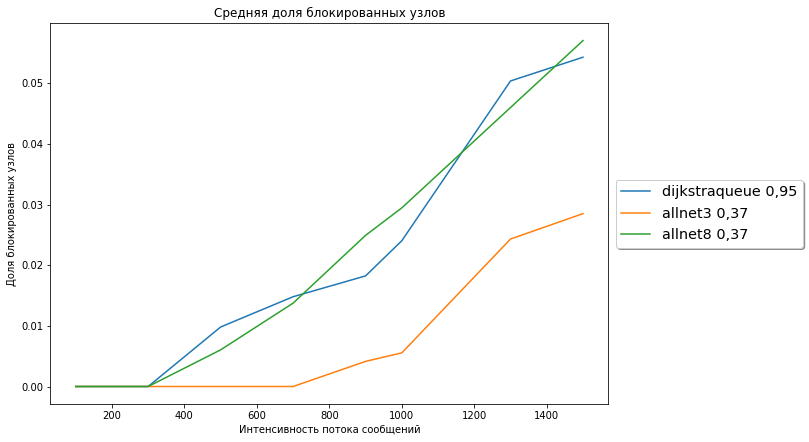

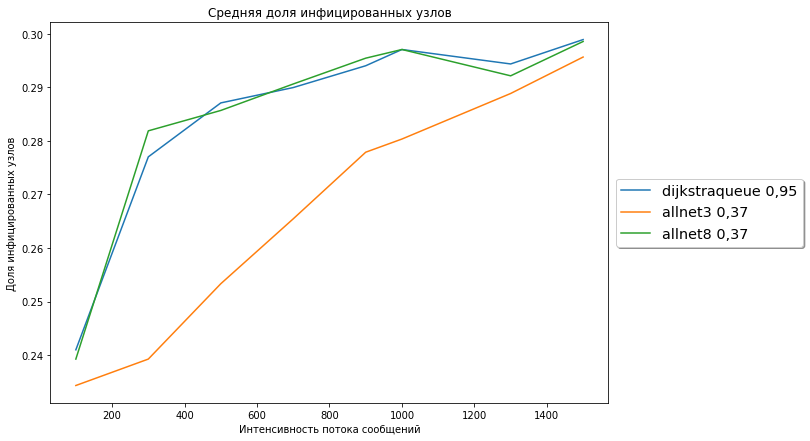

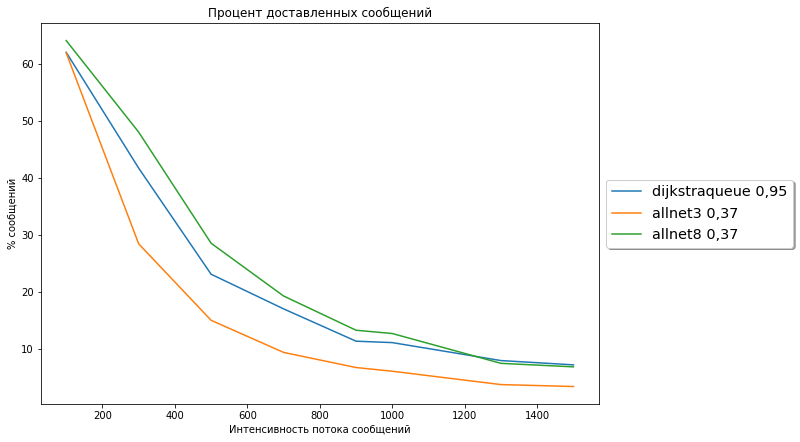

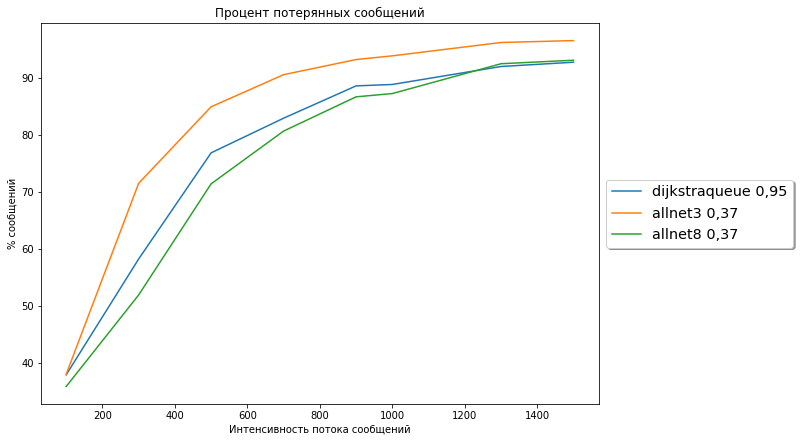

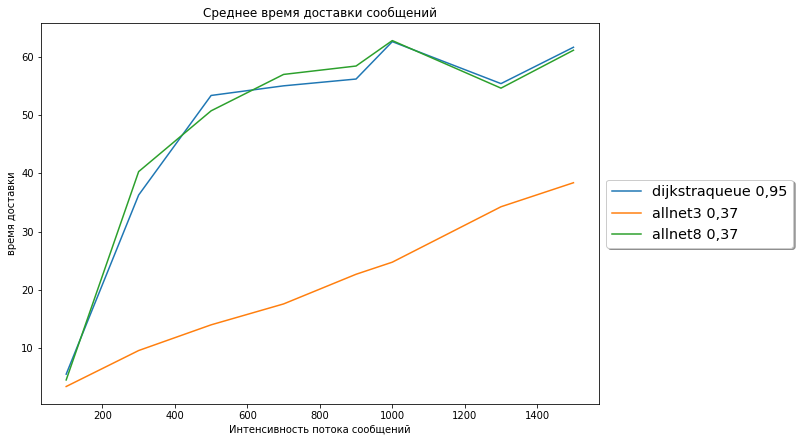

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.021451
allnet3 0,37          0.007816
allnet8 0,37          0.022157

dijkstraqueue 0,95    77.245247
allnet3 0,37          83.083414
allnet8 0,37          74.905149

dijkstraqueue 0,95    48.259755
allnet3 0,37          20.609164
allnet8 0,37          48.692958

dijkstraqueue 0,95    0.284905
allnet3 0,37          0.266872
allnet8 0,37          0.285058
